# Analyzer of Stocks


## Libraries


In [1]:
# Import necessary libraries
from dotenv import load_dotenv
from libs import indicators, signals
import alpaca_trade_api as trade_api
import os
import pandas as pd
import matplotlib.pyplot as plt


## Alpaca Connection


In [2]:
load_dotenv()


True

In [3]:
# Get keys and URL for Alpaca API
alpaca_key = os.getenv('APCA_API_KEY_ID')
alpaca_secret_key = os.getenv('APCA_API_SECRET_KEY')
alpaca_paper_trade_url = os.getenv('APCA_API_PAPER_URL')


In [4]:
# Instantiate Alpaca connection
alpaca = trade_api.REST(alpaca_key, alpaca_secret_key, base_url=alpaca_paper_trade_url)


In [5]:
# Default parameters
ticker = 'TWOU'

today = pd.Timestamp('today')
today_date = f'{today:%Y-%m-%d}'

start_date = pd.Timestamp('2018-01-01', tz='America/New_York').isoformat()

end_date = pd.Timestamp(today_date, tz='America/New_York').isoformat()

timeframe = '1D'


In [6]:
# Get dataframe of ticker data
df_ohlcv_original = alpaca.get_barset(ticker, timeframe, start=start_date, end=end_date).df

# Copy of original dataframe
df_ohlcv = df_ohlcv_original[ticker].copy()


## Bollinger Bands


In [7]:
# Generate Bollinger Band data
df_updated = indicators.bollinger_band_generator(df_ohlcv)


## Keltner Channels


In [8]:
# Generate average true range values
df_updated = indicators.keltner_channel_generator(df_updated)


## EWMA (Fast and Slow)


In [10]:
df_updated = indicators.ewma_generator(df_updated, 12, 26)


## MACD 


In [11]:
df_updated = indicators.macd_generator(df_updated)
df_updated = signals.macd(df_updated, 5)


## Bollinger Bands and Keltner Channels Indicators Plot


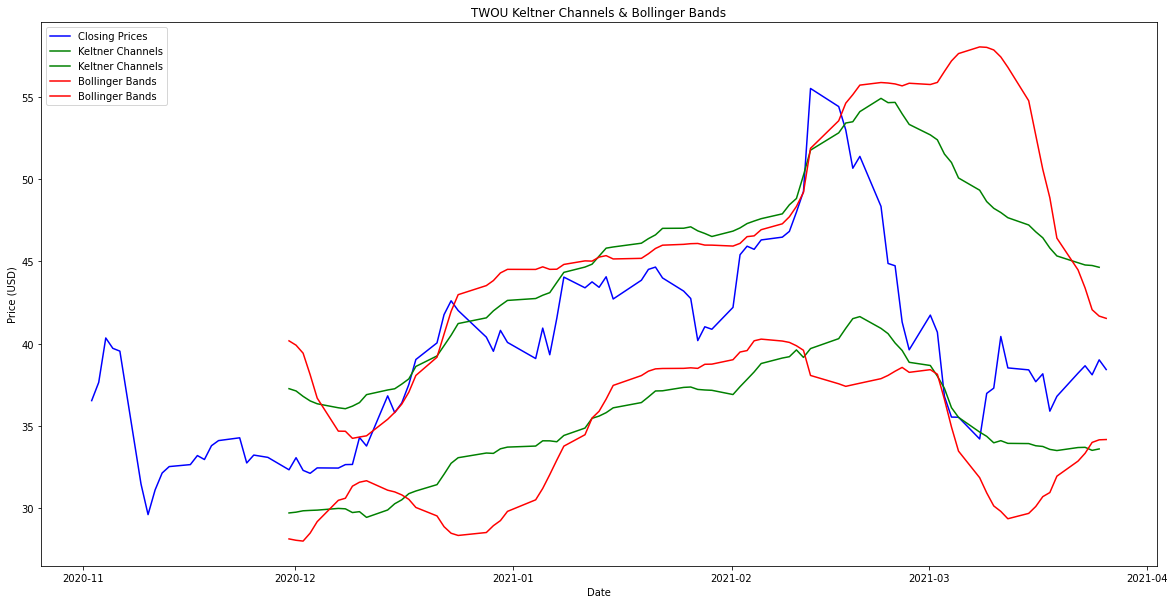

In [12]:
# Generate Keltner Channels and Bollinger Bands plot
plt.figure(figsize=(20,10))
plt.title(f'{ticker} Keltner Channels & Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.plot(df_updated[['close']], color='b', label='Closing Prices')
plt.plot(df_updated[['kc_upper', 'kc_lower']], color="g", label='Keltner Channels')
plt.plot(df_updated[['bb_upper', 'bb_lower']], color="r", label='Bollinger Bands')
plt.legend(loc='upper left')


## MACD Plot


<AxesSubplot:title={'center':'EWMA Fast and Slow'}, xlabel='Date', ylabel='Price (USD)'>

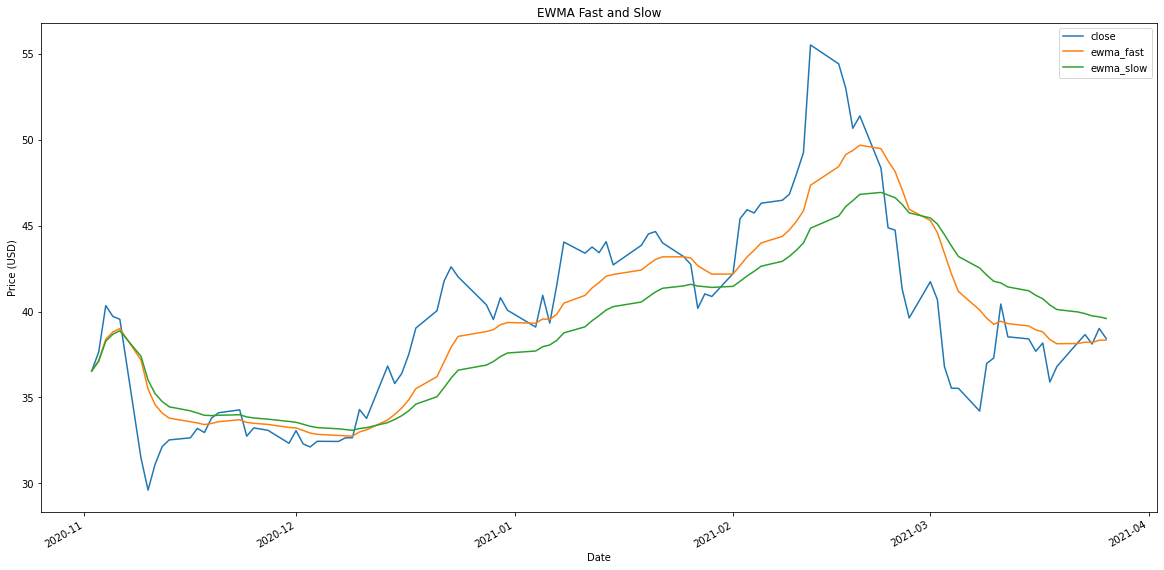

In [13]:
# Generate MACD Fast and Slow plot
df_updated[['close', 'ewma_fast', 'ewma_slow']].plot(figsize=(20,10), title='EWMA Fast and Slow', xlabel='Date', ylabel='Price (USD)')


## MACD Signals


<AxesSubplot:title={'center':'MACD Signal With Divergence'}, xlabel='Date', ylabel='Amount of Divergence'>

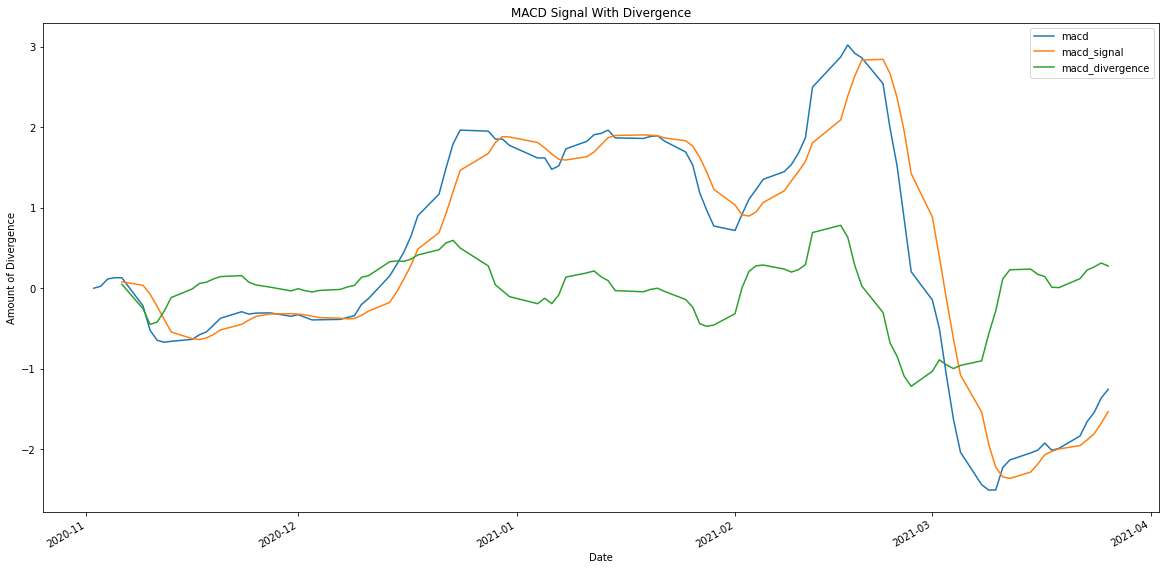

In [14]:
# Generate MACD with signal and divergence lines
df_updated[['macd', 'macd_signal', 'macd_divergence']].plot(figsize=(20,10), title='MACD Signal With Divergence', xlabel='Date', ylabel='Amount of Divergence')


In [15]:
df_updated = signals.bbands_inside_kchannels(df_updated)
df_updated = signals.


,open,high,low,close,volume,bb_upper,bb_middle,bb_lower,atr,kc_upper,kc_middle,kc_lower,ewma_fast,ewma_slow,macd,macd_signal,macd_divergence,squeeze
time,,,,,,,,,,,,,,,,,,
2021-03-22 00:00:00-04:00,36.82,38.78,36.80,38.21,1247563,44.488656,38.6760,32.863344,2.808714,44.923199,39.305771,33.688342,38.140797,39.977764,-1.836967,-1.956437,0.119469,0.0
2021-03-23 00:00:00-04:00,38.72,39.30,37.91,38.66,1283419,43.392593,38.3650,33.337407,2.771692,44.787648,39.244265,33.700882,38.220674,39.880096,-1.659422,-1.885622,0.226200,0.0
2021-03-24 00:00:00-04:00,39.08,39.87,37.45,38.11,1935042,42.067327,38.0335,33.999673,2.809628,44.755489,39.136234,33.516978,38.203647,39.748908,-1.545261,-1.809604,0.264343,1.0
2021-03-25 00:00:00-04:00,37.45,39.25,36.08,39.02,1598960,41.679756,37.9185,34.157244,2.761089,44.647342,39.125163,33.602984,38.329240,39.694888,-1.365648,-1.679673,0.314024,1.0
2021-03-26 00:00:00-04:00,38.98,39.46,37.16,38.43,1017134,41.542287,37.8585,34.174713,NaN,NaN,39.058954,NaN,38.344742,39.601150,-1.256409,-1.532741,0.276333,0.0
